# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy import stats
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder, StandardScaler


# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.imputer as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [3]:
# Check the structure of the data after it's loaded.
print("Demographics data shape: ", azdias.shape)
print("Feature summary data shape: ", feat_info.shape)

# azdias: print the number of rows and columns
print('Rows: {} \
\nColumns: {}'.format(azdias.shape[0], azdias.shape[1]))

azdias.describe(include='all').T

Demographics data shape:  (891221, 85)
Feature summary data shape:  (85, 4)
Rows: 891221 
Columns: 85


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
AGER_TYP,891221.0,NaN,NaN,NaN,-0.358435,1.198724,-1.0,-1.0,-1.0,-1.0,3.0
ALTERSKATEGORIE_GROB,891221.0,NaN,NaN,NaN,2.777398,1.068775,1.0,2.0,3.0,4.0,9.0
ANREDE_KZ,891221.0,NaN,NaN,NaN,1.522098,0.499512,1.0,1.0,2.0,2.0,2.0
CJT_GESAMTTYP,886367.0,NaN,NaN,NaN,3.632838,1.595021,1.0,2.0,4.0,5.0,6.0
FINANZ_MINIMALIST,891221.0,NaN,NaN,NaN,3.074528,1.321055,1.0,2.0,3.0,4.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...
PLZ8_HHZ,774706.0,NaN,NaN,NaN,3.612821,0.973967,1.0,3.0,4.0,4.0,5.0
PLZ8_GBZ,774706.0,NaN,NaN,NaN,3.381087,1.111598,1.0,3.0,3.0,4.0,5.0
ARBEIT,794005.0,NaN,NaN,NaN,3.167854,1.002376,1.0,3.0,3.0,4.0,9.0
ORTSGR_KLS9,794005.0,NaN,NaN,NaN,5.293002,2.303739,0.0,4.0,5.0,7.0,9.0


In [4]:
# 1st glance at stats also transposed
print(f"\n\n 1st glance at stats ")
azdias.describe().transpose().T



 1st glance at stats 


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [5]:
# Create a raw dataset copy
azdias_raw=azdias.copy()

# Identify missing or unknown data values and convert them to NaNs.
# Step 1.1.1: Convert Missing Value Codes to NaNs

# Dictionary for missing value codes per attrib.
mis_code = {}

# feat_info scan
for idx, row in feat_info.iterrows():
    attribute = row['attribute']
    mis_val = row['missing_or_unknown']
    
    #  mis_val is non-empty string?
    if isinstance(mis_val, str) and mis_val.strip():
        # Extract the missing value codes and convert them into a list of integers.
        mis_val = [code.strip() for code in mis_val[1:-1].split(',')]
        
        # Update mis_code dictionary with attribute=key ; missing values = value
        mis_code[attribute] = mis_val

# Replace miss & unknown values with NaNs
for attribute, mis_val in mis_code.items():
    # Attribute exists in azdias ?
    if attribute in azdias.columns:
        # Replace the missing vals with NaNs
        azdias[attribute] = azdias[attribute].replace(mis_val, np.nan)

# After replacement check % of missing values per col
mis_perc = azdias.isnull().sum() / len(azdias) * 100

# Print the % of missing vals per col, unsorted
mis_perc

AGER_TYP                 0.000000
ALTERSKATEGORIE_GROB     0.000000
ANREDE_KZ                0.000000
CJT_GESAMTTYP            0.544646
FINANZ_MINIMALIST        0.000000
                          ...    
PLZ8_HHZ                13.073637
PLZ8_GBZ                13.073637
ARBEIT                  10.908181
ORTSGR_KLS9             10.908181
RELAT_AB                10.908181
Length: 85, dtype: float64

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [6]:
# Eval the % of missing data in each column

# Step 1.1.2: Assess Missing Data in Each Column
# Calculate the percentage of missing values for each column and Sort
mis_perc_cols = (azdias.isnull().mean() * 100).sort_values(ascending=False)
null_data = azdias.isnull().sum()[azdias.isnull().sum() != 0]

data_dict = {'count': null_data.values, 'percent': np.round(null_data.values *100/azdias.shape[0],2)}

azdias_nans = pd.DataFrame(data=data_dict, index=null_data.index)
azdias_nans.sort_values(by='count', ascending=False, inplace=True)
azdias_nans.head(n=20)


,count,percent
KK_KUNDENTYP,584612,65.60
KBA05_BAUMAX,133324,14.96
KBA05_ANTG4,133324,14.96
KBA05_ANTG1,133324,14.96
KBA05_ANTG2,133324,14.96
KBA05_GBZ,133324,14.96
MOBI_REGIO,133324,14.96
KBA05_ANTG3,133324,14.96
KKK,121196,13.60
REGIOTYP,121196,13.60


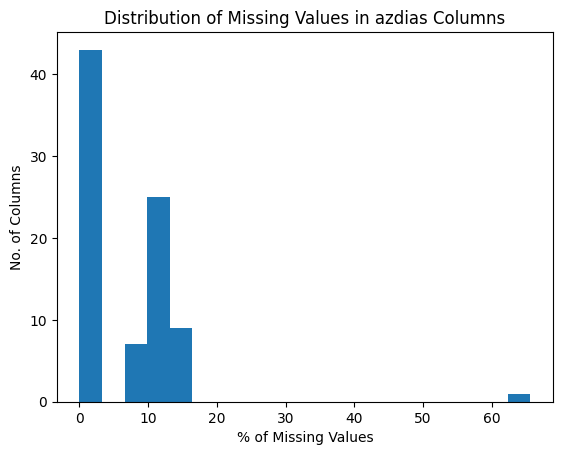

Outlier Columns with 13-15% missing values:
['KBA05_GBZ', 'KBA05_ANTG1', 'KBA05_ANTG3', 'MOBI_REGIO', 'KBA05_ANTG2', 'KBA05_ANTG4', 'KBA05_BAUMAX', 'REGIOTYP', 'KKK', 'PLZ8_HHZ', 'PLZ8_BAUMAX', 'PLZ8_ANTG4', 'PLZ8_GBZ', 'PLZ8_ANTG2', 'PLZ8_ANTG1', 'PLZ8_ANTG3']


In [7]:
# Investigate visual patterns; plot the distribution of missing value counts per col
plt.hist(mis_perc_cols, bins=20)
plt.xlabel("% of Missing Values")
plt.ylabel("No. of Columns")
plt.title("Distribution of Missing Values in azdias Columns")
plt.show()

# Binning: Identify the outlier columns with a higher percentage of missing values (e.g., 13% < miss < 15%)
# out_col = mis_perc_cols[mis_perc_cols > 5].index.tolist()
out_col = mis_perc_cols[(mis_perc_cols > 13) & (mis_perc_cols < 15)].index.tolist()
print("Outlier Columns with 13-15% missing values:")
print(out_col)


### The trimodal distrib in the above histogram reveals a single true outlier >65% miss at the far enf of the tail: 
KK_KUNDENTYP => Consumer pattern over past 12 months (1: regular customer, 6: passive customer). 

In [8]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
# Remove the outlier columns from the dataset.
out_col = mis_perc_cols[mis_perc_cols > 65].index.tolist()
print(f"\nRemoved outlier columns with >65% missing values:", out_col)
# reuse the raw df for azdias_col_clean 
azdias_raw = azdias.drop(columns=out_col)


Remove outlier columns with >65% missing values: ['KK_KUNDENTYP']


#### Discussion 1.1.2: Assess Missing Data in Each Column
- The histogram shows a tri-modal distribution of missing value percentages for each column. Most columns have a relatively low percentage of missing values, while only the column KK_KUNDENTYP has more than 65% missing values, making it an outlier and top removal candidate. Against removal: Could potentially be key wrt. consumer behavior, except (i) it lacks 2/3 of the data; (ii) shopping behavior is also captured by, e.g., SHOPPER_TYP. 
- Final decision: KK_KUNDENTYP is dropped.

- The central mode reveals ~40 cols with 8% < misses < 15%, affected by 2 notable correlation patterns:
- 1) 13.07% => 'PLZ8_HHZ', 'PLZ8_BAUMAX', 'PLZ8_ANTG4', 'PLZ8_GBZ', 'PLZ8_ANTG2', 'PLZ8_ANTG1', 'PLZ8_ANTG3'
- 2) 14.96% => 'KBA05_GBZ', 'KBA05_ANTG1', 'KBA05_ANTG3', 'MOBI_REGIO', 'KBA05_ANTG2', 'KBA05_ANTG4', 'KBA05_BAUMAX'

PLZ8_ANTGx are macro cell features with the same 13.07% misses, ie., affecting the same people/rows across the dataset. Ditto for the 14.96% cols. However, the data dictionary indicates potentially relevant data for clustering, hence no drop. 

Net: The column KK_KUNDENTYP was removed from the dataset due to its high percentage of missing values. All other columns are retained for further data engineering tasks, such as re-encoding and imputation, to handle the remaining missing data and prepare the data for clustering.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

 697612 rows (78.28%) w/o missing data
 193609 rows (21.72%) with missing data


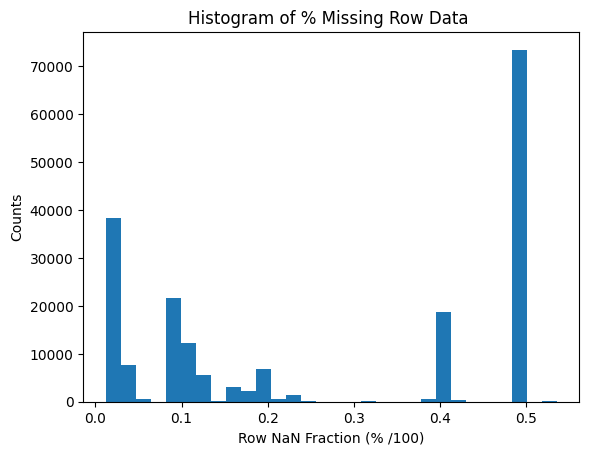

In [10]:
# How much data is missing in each row of the dataset?

# Step 1.1.3: Assess Missing Data in Each Row
# Count NaNs by row
r_NaNs_all = azdias_raw.isnull().sum(axis=1)
r_NaNs = azdias_raw.isnull().sum(axis=1)[azdias_raw.isnull().sum(axis=1) > 0]

#  % of rows with missing data; high to low
r_NaN_pct_all = r_NaNs_all/(azdias_raw.shape[1])
r_NaN_pct = r_NaNs/(azdias_raw.shape[1])
r_NaN_pct.sort_values(ascending=False,inplace=True)

# How many rows have missing data?
print(" {} rows ({:0.2f}%) w/o missing data".format(azdias_raw.shape[0]-r_NaNs.count(),(azdias_raw.shape[0]-r_NaNs.count())/azdias_raw.shape[0]*100))
print(" {} rows ({:0.2f}%) with missing data".format(r_NaNs.count(),r_NaNs.count()/azdias_raw.shape[0]*100))

# Histo plot the missing row data
plt.hist(r_NaN_pct, bins=30)
plt.xlabel('Row NaN Fraction (% /100)')
plt.ylabel('Counts')
plt.title('Histogram of % Missing Row Data ')
plt.show()

### The histogram suggests a threshold Th=30% for Low vs. High miss per row cut-off.

In [11]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# Set the Th = 30% as r_cut_off
r_cut_off=0.30

# New column for % of missing data / row
azdias_raw = azdias_raw.assign(NAN_PCT=pd.Series(r_NaN_pct_all.values))

# Split data into 2 subsets 'hi_NaN_r' and 'lo_NaN_r' based on my cut-off thshld
hi_NaN_r = azdias_raw[azdias_raw['NAN_PCT'] >= r_cut_off].copy()
lo_NaN_r = azdias_raw[azdias_raw['NAN_PCT'] < r_cut_off].copy()

print(' {} rows in hi_NaN_r'.format(hi_NaN_r.shape[0]))
print('{} rows in lo_NaN_r: \n'.format(lo_NaN_r.shape[0]))

 93218 rows in hi_NaN_r
798003 rows in lo_NaN_r: 



## Verify: Null hypothesis => Are the Hi and Lo (row Nans) distributions drawn from the same source ?

['SEMIO_TRADV', 'PRAEGENDE_JUGENDJAHRE', 'FINANZ_UNAUFFAELLIGER', 'SEMIO_LUST', 'SEMIO_MAT']


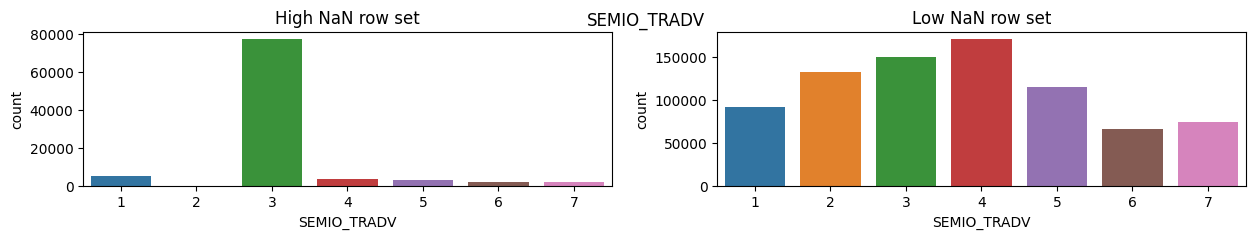

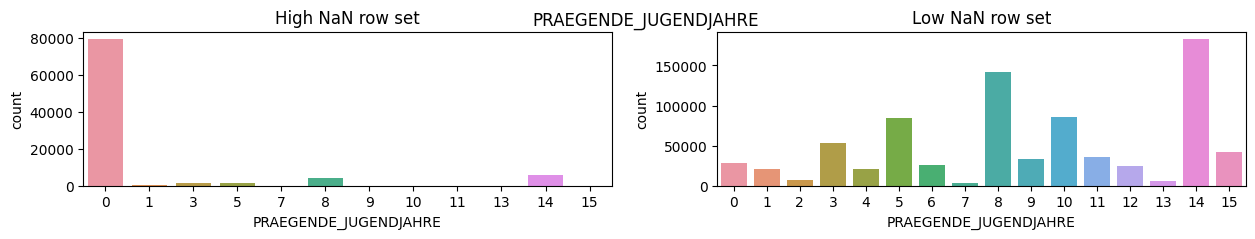

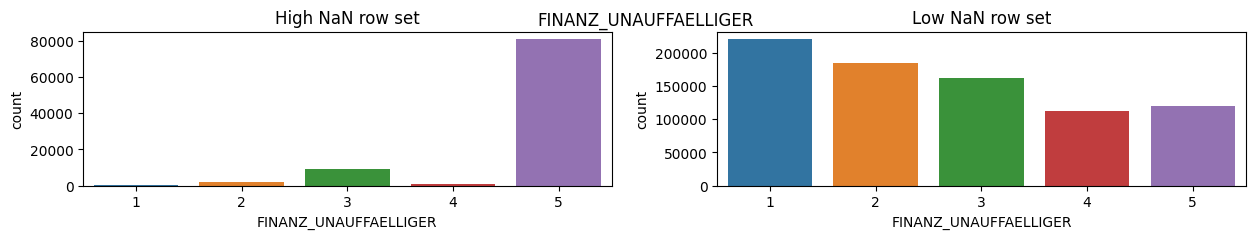

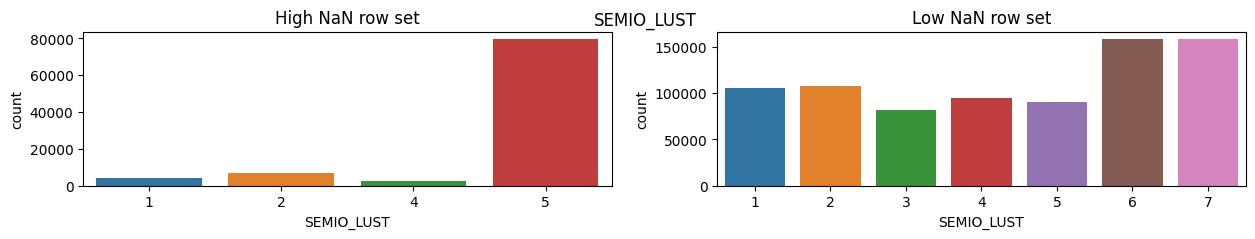

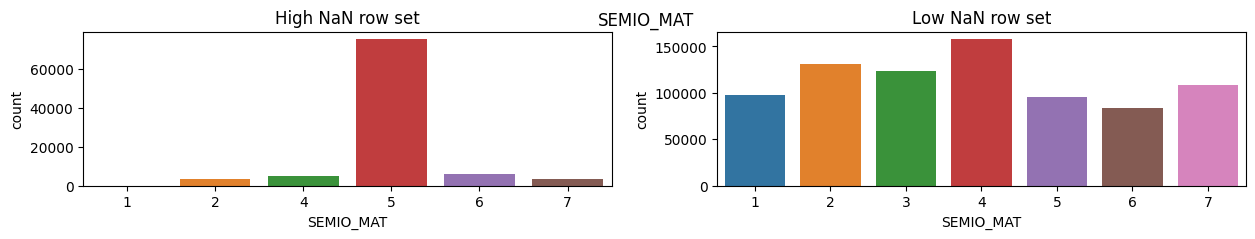

In [15]:
def compare_dist_countplot(df1, df2, col_name):
    """
    Compare per col. val distribs between 2 subsets

    Parameters:
        df1 (DataFrame): 1st DataFrame subset.
        df2 (DataFrame): 2nd DataFrame subset.
        col_name (str): Name of the column to compare.

    Returns:
        None. Displays count plots of the column's distribution.
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 2))
    
    sns.countplot(data=df1, x=col_name, ax=axes[0])
    axes[0].set_title('High NaN row set')
    
    sns.countplot(data=df2, x=col_name, ax=axes[1])
    axes[1].set_title('Low NaN row set')
    
    fig.suptitle(col_name)
    plt.show()

# Randomly select K cols w/o missing values
np.random.seed(42)
k_cols = np.random.choice(azdias_raw.dropna(axis=1).columns, 5).tolist()
print(k_cols)

# Loop for each column in the list to compare distributions
for col in k_cols:
    compare_dist_countplot(hi_NaN_r, lo_NaN_r, col)


### Use Kolmogorov-Smirnov test to validate the visual histo => Two different distribs, proceed w/ care...

In [19]:
from scipy import stats

# double check the visual histo via a brief Kolmogorov-Smirnov test
for col in k_cols:
   print('KST for {} on Hi/Lo subsets=> {}'.format(col,stats.ks_2samp(hi_NaN_r[col],lo_NaN_r[col])))

KST for SEMIO_TRADV on Hi/Lo subsets=> KstestResult(statistic=0.42107248255102075, pvalue=0.0, statistic_location=3, statistic_sign=1)
KST for PRAEGENDE_JUGENDJAHRE on Hi/Lo subsets=> KstestResult(statistic=0.8158416555750558, pvalue=0.0, statistic_location=0, statistic_sign=1)
KST for FINANZ_UNAUFFAELLIGER on Hi/Lo subsets=> KstestResult(statistic=0.7187827144124928, pvalue=0.0, statistic_location=4, statistic_sign=-1)
KST for SEMIO_LUST on Hi/Lo subsets=> KstestResult(statistic=0.3970636701867035, pvalue=0.0, statistic_location=5, statistic_sign=1)
KST for SEMIO_MAT on Hi/Lo subsets=> KstestResult(statistic=0.5511829649145812, pvalue=0.0, statistic_location=4, statistic_sign=-1)


### Notice pvalue=0.0 => Different distribs => Dropping incurs high bias risk!

In [20]:
# How many rows are above the Th of missing values?
print(" {} rows ({:0.2f}%) have NaNs > {:0.0f}% of the".format(hi_NaN_r.shape[0],hi_NaN_r.shape[0]/azdias_raw.shape[0]*100,r_cut_off*100))
print('{} initial rows, i.e., before dropping the Hi outliers.'.format(azdias_raw.shape[0]))

# Drop and save as our new df
azdias_clean=azdias_raw[azdias_raw['NAN_PCT'] < r_cut_off].copy()

# Total no. rows left in our new dataset
print('{} rows are left after dropping the Hi set.'.format(azdias_clean.shape[0]),'\n')

print("Cleaned dataset SHAPE: {} rows w/ {} columns. ".format(azdias_clean.shape[0],azdias_clean.shape[1]))

 93218 rows (10.46%) have NaNs > 30% of the
891221 initial rows, i.e., before dropping the Hi outliers.
798003 rows are left after dropping the Hi set. 

Cleaned dataset SHAPE: 798003 rows w/ 85 columns. 


#### Discussion 1.1.3: Assess Missing Data in Each Row

The null hypothesis that the Hi and Lo (row Nans) distributions are drawn from the same source is rejected! 
- As confirmed also by the Kolmogorov-Smirnov Test (the extended version was not included here for brevity) with p-values are extremely low (<0.0001), the above 2 sets draw from dissimilar distribs => too vastly different to drop w/o introducing a potentially massive statistical bias. Hence despite the temptation to sanitize by dropping rows from the High miss subset, this 10.45% data loss could incurr the danger of distortioning the true distrib.

However,  given the nearly 1M rows,  the <10.5% data loss could be quantitatively tolerated iff dropping the rows with >1/3 missing columns doesn't skew/bias the results above a statistically accepted margin.
- Net: Being aware of the perils involved, hereby we shall break the rules and choose to drop the Hi set.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [21]:
# How many features are there of each data type?
# Remove the outlier columns also from feat_info

print("Original feat_info\n",feat_info.type.value_counts(),'\n')
print("Outlier Columns: ", out_col,'\n')

#Drop the outliers (KK_kundentyp)
# feat_info = feat_info[~feat_info.attribute.isin(out_col)]
# print("feat_info w/o outlier columns\n",feat_info.type.value_counts())

feat_info = feat_info.set_index('attribute').drop(out_col).reset_index()

Original feat_info
 type
ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: count, dtype: int64 

Outlier Columns:  ['KK_KUNDENTYP'] 



#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [22]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# new dictionary: keys = 4 data types above;  Vals = corresponding DF columns
df_dtype = {}
dtypes = ['ordinal','categorical','numeric','mixed']
for d in dtypes:
    df_dtype[d]=feat_info[feat_info['type']==d]['attribute']

### Handling the special types
Categoricals
- Ordinal Categoricals: Convert into numeric ordinals iff necessary and keep the same for simplicity
- Multi-Level Categoricals: One-Hot Encode
- Binary Categoricals: Convert into binary

Numeric: no change

Mixed: Analyse

In [23]:
# Re-encode categorical variable(s) to be kept in the analysis.

def check_unique_vals(df):
    """
    Print unique values for each column in the DataFrame.

    Parameters:
        df (DataFrame): The DataFrame to check for unique values.

    Returns:
        None. Prints unique values for each column.
    """
    for col in df.columns:
        values = list(df[col].unique())
        print(f'{col}: {values}')


In [24]:
# Ordinals: check if numeric, w/o strings to handle
check_unique_vals(azdias_clean[df_dtype['ordinal']])

ALTERSKATEGORIE_GROB: [1, 3, 4, 2, 9]
FINANZ_MINIMALIST: [1, 4, 3, 2, 5]
FINANZ_SPARER: [5, 4, 2, 3, 1]
FINANZ_VORSORGER: [2, 1, 5, 4, 3]
FINANZ_ANLEGER: [5, 2, 1, 4, 3]
FINANZ_UNAUFFAELLIGER: [4, 3, 1, 2, 5]
FINANZ_HAUSBAUER: [5, 2, 3, 4, 1]
HEALTH_TYP: [3, 2, 1, -1]
RETOURTYP_BK_S: [1.0, 3.0, 2.0, 5.0, 4.0, nan]
SEMIO_SOZ: [5, 4, 6, 2, 7, 3, 1]
SEMIO_FAM: [4, 1, 5, 7, 2, 6, 3]
SEMIO_REL: [4, 3, 2, 7, 5, 1, 6]
SEMIO_MAT: [3, 1, 2, 4, 7, 5, 6]
SEMIO_VERT: [1, 4, 7, 2, 6, 5, 3]
SEMIO_LUST: [2, 4, 6, 7, 3, 1, 5]
SEMIO_ERL: [2, 6, 7, 4, 5, 1, 3]
SEMIO_KULT: [3, 4, 6, 5, 7, 1, 2]
SEMIO_RAT: [6, 4, 3, 2, 7, 5, 1]
SEMIO_KRIT: [4, 7, 3, 1, 5, 6, 2]
SEMIO_DOM: [7, 4, 2, 1, 5, 6, 3]
SEMIO_KAEM: [4, 7, 5, 2, 3, 6, 1]
SEMIO_PFLICHT: [7, 3, 4, 5, 1, 6, 2]
SEMIO_TRADV: [6, 3, 4, 2, 7, 5, 1]
HH_EINKOMMEN_SCORE: [6.0, 4.0, 1.0, 5.0, 3.0, 2.0]
W_KEIT_KIND_HH: [3.0, nan, 2.0, 6.0, 5.0, 4.0, 0.0, 1.0]
WOHNDAUER_2008: [9.0, 8.0, 3.0, 4.0, 5.0, 6.0, 2.0, 7.0, 1.0]
KONSUMNAEHE: [1.0, 5.0, 4.0, 3.0, 2.0, 6.

## Categoricals: Binary and Multi_level

In [25]:
# Show the binary and multi-level categoricals
cat_bin = []; cat_ml = []
for col in azdias_clean[df_dtype['categorical']]:
    values = azdias_clean[df_dtype['categorical']][col].nunique()
    if values == 2:
        cat_bin.append(col)
    else:
        cat_ml.append(col)
    print(f'{col}: {values}')
    
azdias_clean[cat_bin].head()

AGER_TYP: 5
ANREDE_KZ: 2
CJT_GESAMTTYP: 6
FINANZTYP: 6
GFK_URLAUBERTYP: 12
GREEN_AVANTGARDE: 2
LP_FAMILIE_FEIN: 12
LP_FAMILIE_GROB: 6
LP_STATUS_FEIN: 10
LP_STATUS_GROB: 5
NATIONALITAET_KZ: 4
SHOPPER_TYP: 5
SOHO_KZ: 2
TITEL_KZ: 6
VERS_TYP: 3
ZABEOTYP: 6
GEBAEUDETYP: 7
OST_WEST_KZ: 2
CAMEO_DEUG_2015: 9
CAMEO_DEU_2015: 44


,ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,OST_WEST_KZ
1,2,0,1.0,W
2,2,1,0.0,W
3,2,0,0.0,W
4,1,0,0.0,W
5,2,0,0.0,W


### TODO => "OST_WEST_KZ" isn't numerical => handle as ML-cat.

In [28]:
# Group it w/ the multi-level categoricals
cat_ml.append('OST_WEST_KZ')

# counts of East and West values
azdias_clean['OST_WEST_KZ'].value_counts()

OST_WEST_KZ
W    629468
O    168535
Name: count, dtype: int64

In [29]:
# Multi-Level Categoricals => One-Hot Encode later
azdias_clean[cat_ml].head()

,AGER_TYP,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,TITEL_KZ,VERS_TYP,ZABEOTYP,GEBAEUDETYP,CAMEO_DEUG_2015,CAMEO_DEU_2015,OST_WEST_KZ,OST_WEST_KZ
1,-1,5.0,1,10.0,5.0,3.0,2.0,1.0,1,3,0.0,2,5,8.0,8,8A,W,W
2,-1,3.0,1,10.0,1.0,1.0,3.0,2.0,1,2,0.0,1,5,1.0,4,4C,W,W
3,2,2.0,6,1.0,0.0,0.0,9.0,4.0,1,1,0.0,1,3,1.0,2,2A,W,W
4,-1,5.0,5,5.0,10.0,5.0,3.0,2.0,1,2,0.0,2,4,1.0,6,6B,W,W
5,3,2.0,2,1.0,1.0,1.0,4.0,2.0,1,0,0.0,2,4,1.0,8,8C,W,W


In [30]:
# Check numericals for QC
azdias_clean[df_dtype['numeric']].describe()

,GEBURTSJAHR,ANZ_PERSONEN,ANZ_TITEL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,MIN_GEBAEUDEJAHR,KBA13_ANZAHL_PKW
count,798003.000000,798003.000000,798003.000000,798003.000000,794143.000000,798003.000000,785385.000000
mean,1200.742257,1.728841,0.004159,8.287652,0.040648,1993.275616,619.698822
std,959.365728,1.156555,0.068872,15.628523,0.324039,3.329176,340.035609
min,0.000000,0.000000,0.000000,0.000000,0.000000,1985.000000,0.000000
25%,0.000000,1.000000,0.000000,1.000000,0.000000,1992.000000,384.000000
50%,1950.000000,1.000000,0.000000,4.000000,0.000000,1992.000000,549.000000
75%,1972.000000,2.000000,0.000000,9.000000,0.000000,1993.000000,778.000000
max,2017.000000,45.000000,6.000000,595.000000,23.000000,2016.000000,2300.000000


In [31]:
# Mixed types elicit attention...
azdias_clean[df_dtype['mixed']].head()

,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,WOHNLAGE,CAMEO_INTL_2015,KBA05_BAUMAX,PLZ8_BAUMAX
1,21.0,6.0,14,4.0,51,5.0,1.0
2,3.0,1.0,15,2.0,24,0.0,1.0
3,0.0,0.0,8,7.0,12,1.0,1.0
4,32.0,10.0,8,3.0,43,0.0,2.0
5,8.0,2.0,3,7.0,54,0.0,1.0


In [32]:
# Check the unique values of mixed feats
for column in azdias_clean[df_dtype['mixed']].columns:
    print(column,azdias_clean[df_dtype['mixed']][column].nunique())

LP_LEBENSPHASE_FEIN 41
LP_LEBENSPHASE_GROB 13
PRAEGENDE_JUGENDJAHRE 16
WOHNLAGE 8
CAMEO_INTL_2015 21
KBA05_BAUMAX 6
PLZ8_BAUMAX 5


See mixed above (and the dictionary); hence all categoricals thus far => encode as multi-level via one-hot encoding;

TBD for later the more complex feats
- (a) "PRAEGENDE_JUGENDJAHRE"  
- (b) "CAMEO_INTL_2015".

### One-hot-encode (OHE) all ML categoricals and mixed, except the 2 special cases
Naturally this will explode the feature cardinal by a factor 3-4x...!

In [33]:
for col in df_dtype['mixed']:
    if col not in ['CAMEO_INTL_2015','PRAEGENDE_JUGENDJAHRE']:
        cat_ml.append(col)

# Proceed to OH-encoding for ML categs and mixed => Attention: One-time, or reload the df from the top...
azdias_ohe=pd.get_dummies(azdias_clean,columns=cat_ml)

# Print the shape of the new df
print("Shape OH-encoded frame:", azdias_ohe.shape)

Shape OH-encoded frame: (798003, 286)


#### Discussion 1.2.1: Re-Encode Categorical Features

The steps are documented above; 
- we've maintained the ordinal and numeric columns unchanged; 
- one-hot encoded multi-level categorical, hence the 83 features exploded to 357;

Sundry others, e.g. 
- the hidden binary (two-level) categorical `OST_WEST_KZ` we re-encoded to [0,1];
- the (two-level) categoricals e.g., `ANREDE_KZ`m `VERS_TYP` with initial values [2,1], we also re-encoded to [0,1].

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

### Wrangle the Mixed Features
- "PRAEGENDE_JUGENDJAHRE" = 3D info on generation by decade, movement, and nation 
- "CAMEO_INTL_2015" = 2D info on wealth and life stage.

Break-down 2-digit codes on 10s-pos. and 'ones'=> 2 ordinal variables, i.e., here as numeric vals

"PRAEGENDE_JUGENDJAHRE" from the Data_Dictionary.md
 - 1:  40s war years (Mainstream, E+W)
 - 2:  40s reconstruction years (Avantgarde, E+W)
 - 3:  50s economic miracle (Mainstream, E+W)
 - 4:  50s milk bar / Individualisation (Avantgarde, E+W)
 - 5:  60s economic miracle (Mainstream, E+W)
 - 6:  60s generation 68 / student protestors (Avantgarde, W)
 - 7:  60s opponents to the building of the Wall (Avantgarde, E)
 - 8:  70s family orientation (Mainstream, E+W)
 - 9:  70s peace movement (Avantgarde, E+W)
 - 10: 80s Generation Golf (Mainstream, W)
 - 11: 80s ecological awareness (Avantgarde, W)
 - 12: 80s FDJ / communist party youth organisation (Mainstream, E)
 - 13: 80s Swords into ploughshares (Avantgarde, E)
 - 14: 90s digital media kids (Mainstream, E+W)
 - 15: 90s ecological awareness (Avantgarde, E+W)

Obs: This is extremely interesting as classification, of high value!

In [34]:
# manually handle the "PRAEGENDE_JUGENDJAHRE" via 2 new vars
movement = []; decade = []
for val in azdias_ohe['PRAEGENDE_JUGENDJAHRE']:
    # Remap movement
    if val in [1,3,5,8,10,12,14]:
        movement.append(0) 
    elif val in [2,4,6,7,9,11,13,15]:
        movement.append(1)
    else:
        movement.append(np.NaN)
    # Remap decade  
    if val in [1,2]:
        decade.append(40)
    elif val in [3,4]:
        decade.append(50)
    elif val in [5,6,7]:
        decade.append(60)
    elif val in [8,9]:
        decade.append(70)
    elif val in [10,11,12]:
        decade.append(80)
    elif val in [13,14,15]:
        decade.append(90)
    else:
        decade.append(np.NaN)

# check the consistency, if they all match before/after
len(movement)==azdias_ohe.shape[0]==len(decade)

True

In [35]:
# frugal checks on PRAEGENDE_JUGENDJAHRE after
movement = pd.Series(movement)
decade = pd.Series(decade)
azdias_ohe['movement']=movement
print(azdias_ohe['movement'].value_counts())
azdias_ohe['decade']=decade
print(azdias_ohe['decade'].value_counts())

movement
0.0    531585
1.0    156791
Name: count, dtype: int64
decade
90.0    206919
70.0    156781
80.0    130613
60.0    102429
50.0     66521
40.0     25113
Name: count, dtype: int64


### Ditto for CAMEO: Wealth / Life Stage Typology, mapped to international code

 -  -1: unknown
 - 11: Wealthy Households - Pre-Family Couples & Singles
 - 12: Wealthy Households - Young Couples With Children
 - 13: Wealthy Households - Families With School Age Children
 - 14: Wealthy Households - Older Families & Mature Couples
 - 15: Wealthy Households - Elders In Retirement
 - 21: Prosperous Households - Pre-Family Couples & Singles
 - 22: Prosperous Households - Young Couples With Children
 - 23: Prosperous Households - Families With School Age Children
 - 24: Prosperous Households - Older Families & Mature Couples
 - 25: Prosperous Households - Elders In Retirement
 - 31: Comfortable Households - Pre-Family Couples & Singles
 - 32: Comfortable Households - Young Couples With Children
 - 33: Comfortable Households - Families With School Age Children
 - 34: Comfortable Households - Older Families & Mature Couples
 - 35: Comfortable Households - Elders In Retirement
 - 41: Less Affluent Households - Pre-Family Couples & Singles
 - 42: Less Affluent Households - Young Couples With Children
 - 43: Less Affluent Households - Families With School Age Children
 - 44: Less Affluent Households - Older Families & Mature Couples
 - 45: Less Affluent Households - Elders In Retirement
 - 51: Poorer Households - Pre-Family Couples & Singles
 - 52: Poorer Households - Young Couples With Children
 - 53: Poorer Households - Families With School Age Children
 - 54: Poorer Households - Older Families & Mature Couples
 - 55: Poorer Households - Elders In Retirement
 - XX: unknown

In [36]:
# Handle the "CAMEO_INTL_2015"
cameo_intl = []
for val in azdias_ohe['CAMEO_INTL_2015']:
    try:
        val = int(val)
        if 10 < val < 19:
            cameo_intl.append(5)
        elif 20 < val < 29:
            cameo_intl.append(4)
        elif 30 < val < 39:
            cameo_intl.append(3)
        elif 40 < val < 49:
            cameo_intl.append(2)
        elif 50 < val < 59:
            cameo_intl.append(1)
        else:
            cameo_intl.append(np.nan)
    except:
        cameo_intl.append(np.nan)


In [37]:
cameo_intl = pd.Series(cameo_intl)
azdias_ohe['cameo_intl'] = cameo_intl
azdias_ohe.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,...,KBA05_BAUMAX_4.0,KBA05_BAUMAX_5.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0,movement,decade,cameo_intl
1,1,2,1,5,2,5,4,5,1996,0,...,False,True,True,False,False,False,False,1.0,90.0,4.0
2,3,2,1,4,1,2,3,5,1979,1,...,False,False,True,False,False,False,False,0.0,70.0,5.0
3,4,2,4,2,5,2,1,2,1957,0,...,False,False,True,False,False,False,False,0.0,70.0,2.0
4,3,1,4,3,4,1,3,2,1963,0,...,False,False,False,True,False,False,False,0.0,50.0,1.0
5,1,2,3,1,5,2,2,5,1943,0,...,False,False,True,False,False,False,False,0.0,80.0,4.0


In [38]:
# Drop and replace the 2 special cases => 'CAMEO_INTL_2015'& 'PRAEGENDE_JUGENDJAHRE'
azdias_ohe.drop(['CAMEO_INTL_2015','PRAEGENDE_JUGENDJAHRE'],axis=1,inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

We have 6 mixed-type features `LP_LEBENSPHASE_FEIN`, `LP_LEBENSPHASE_GROB`, `PRAEGENDE_JUGENDJAHRE`, `WOHNLAGE`, `CAMEO_INTL_2015`, `PLZ8_BAUMAX`: Two of the mixed-type features `PRAEGENDE_JUGENDJAHRE` and `CAMEO_INTL_2015` have been engineered according to the instructions and documentation in `Data_Dictionary.md`

- PRAEGENDE_JUGENDJAHRE was replaced by 2 new columns: movement and decade, according to the mapping in Data_Dictionary.md.

- CAMEO_INTL_2015 was replaced by a new column cameo_intl, according to the mapping in Data_Dictionary.md.



#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

### Build the cross-correlation matrix
The x-corr. matrix is computationally expensive O(N^2); ideally this should be performed primarily in the EARLY feat-eng. stages: e.g., before cleaning the cols and rows, and also before and after re-encoding (OHE etc.)

In [39]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# ATTENTION: Very slow and irreversible: Once dropped using this method, 
# the SAME feature cleaning MUST also be used in the "Cleaning function" below => 2x runtime
# Check for correlations between features (just in case we could drop some)

def xcorr_candidate(df):
    """
    Get pairs of column indices that are redundant (lower triangular and diagonal).

    Parameters:
        df (DataFrame): The DataFrame for which to find redundant pairs.

    Returns:
        set: A set of pairs of redundant column indices.
    """
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def top_xcorr(df, n=3):
    """
    Get top abs. x-correlations in df.

    Parameters:
        df (DataFrame): The df for which to calculate x-correlations.
        n (int): no. of top x-correlations to retrieve.

    Returns:
        Series: top abs. cross-correlations.
    """
    au_xcorr = df.corr().abs().unstack()
    drop_candidate = xcorr_candidate(df)
    au_xcorr = au_xcorr.drop(labels=drop_candidate).sort_values(ascending=False)
    return au_xcorr.head(n)

# Example usage
start_time = time.time()
print("Top x-Correlations:")
print(top_xcorr(azdias_ohe))
print("--- Run time: %s mins ---" % np.round(((time.time() - start_time) / 60), 2))



Top x-Correlations:
LP_FAMILIE_FEIN_2.0  LP_FAMILIE_GROB_2.0    1.0
LP_FAMILIE_FEIN_1.0  LP_FAMILIE_GROB_1.0    1.0
LP_STATUS_FEIN_10.0  LP_STATUS_GROB_5.0     1.0
dtype: float64
--- Run time: 5.88 mins ---


These strongly x-correlated feats can be removed, and possibly a few others beyond n=5 (too long to run)

In [40]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

#check df shape after cleaning 
if 'NAN_PCT' in azdias_ohe.columns:
    azdias_ohe = azdias_ohe.drop(['NAN_PCT'], axis=1)
    
print("{} rows and {} columns left in our partly cleaned azdias df: \n".format(azdias_ohe.shape[0],azdias_ohe.shape[1]))
print("Features: \n",azdias_ohe.columns.tolist())


798003 rows and 286 columns left in our partly cleaned azdias df: 

Features: 
 ['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GEBURTSJAHR', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SOHO_KZ', 'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO', 'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_HHZ', 'PLZ8_GBZ', 'ARBEIT', 'ORTSGR_KLS9', 'RELA

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [43]:
def STL(x):
    '''
    String of an alphanumeric list => list of STR and INT
      
    IN : STR list, e.g '[-1,0,XX]')
    OUT: List data type
    '''
    new_list=[]
    # The below line removes the '[]' and splits on ',', creating a list of strings
    x = x[1:-1].split(',')
    # For each value in the list of strings, try turning it into an integer if possible and append to new_list
        # Otherwise, append it to new_list
    for i in x:
        try:
            new_list.append(int(i))
        except:
            new_list.append(i)
    return new_list

def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')
    feat_info['NA_tags'] = feat_info['missing_or_unknown'].apply(STL)
    att_index = feat_info.set_index('attribute')
    # Loop thru our feats
    for column in df.columns:
        # For every col. in our DF, if a value is in the 'NA_tags' list, we replace it inplace with np.NaN
        df[column].replace(att_index.loc[column].loc['NA_tags'],np.NaN,inplace=True)    
    att_index = feat_info.set_index('attribute')
    
    # drop the single outlier column KK_KUNDENTYP
    out_col = ['KK_KUNDENTYP']
    df.drop(labels=out_col,axis=1,inplace=True)

    # drop Rows missing > K vals
    df['no_na_row'] = df.isna().sum(axis=1)
    df = df[df['no_na_row'] <= 25 ]
    df.drop('no_na_row',inplace=True,axis=1)
    
    # feat-engineer our cols 
    feat_info = feat_info.set_index('attribute').drop(out_col).reset_index()
    df_dtype = {}
    dtypes = ['ordinal','categorical','numeric','mixed']
    for d in dtypes:
        df_dtype[d]=feat_info[feat_info['type']==d]['attribute']    
    
    #  handle binary v. multilevel categorical 
    cat_bins = []
    cat_mls = []
    for col in df[df_dtype['categorical']]:
        values = df[df_dtype['categorical']][col].nunique()
        if values == 2:
            cat_bins.append(col)
        else:
            cat_mls.append(col)
    
    # move OST_WEST_KZ in the OHE list
    cat_mls.append('OST_WEST_KZ')
    for col in df_dtype['mixed']:
        if col not in ['CAMEO_INTL_2015','PRAEGENDE_JUGENDJAHRE']:
            cat_mls.append(col)
    
    # OHE / One-hot encoding ... Feature explosion, check!
    df = pd.get_dummies(df,columns=cat_mls)
    
    #  handle manually the 2 special mixed vars
    movement = [];     decade = []
    for val in df['PRAEGENDE_JUGENDJAHRE']:
        # Mapping for movement
        if val in [1,3,5,8,10,12,14]:
            movement.append(0) 
        elif val in [2,4,6,7,9,11,13,15]:
            movement.append(1)
        else:
            movement.append(np.NaN)
        # Mapping for decade  
        if val in [1,2]:
            decade.append(40)
        elif val in [3,4]:
            decade.append(50)
        elif val in [5,6,7]:
            decade.append(60)
        elif val in [8,9]:
            decade.append(70)
        elif val in [10,11,12]:
            decade.append(80)
        elif val in [13,14,15]:
            decade.append(90)
        else:
            decade.append(np.NaN)
    movement = pd.Series(movement)
    decade = pd.Series(decade)
    df['decade']=decade
    df['movement']=movement
             
    cameo_intl = []
    for val in df['CAMEO_INTL_2015']:
        try:
            val = int(val)
            if 10 < val < 19:
                cameo_intl.append(5)
            elif 20 < val < 29:
                cameo_intl.append(4)
            elif 30 < val < 39:
                cameo_intl.append(3)
            elif 40 < val < 49:
                cameo_intl.append(2)
            elif 50 < val < 59:
                cameo_intl.append(1)
            else:
                cameo_intl.append(np.nan)
        except:
            cameo_intl.append(np.nan)
    cameo_intl = pd.Series(cameo_intl)
    df['cameo_intl'] = cameo_intl
    df.drop(['CAMEO_INTL_2015','PRAEGENDE_JUGENDJAHRE'],axis=1,inplace=True)            
            
    return df
    

In [44]:
# # test the cleaning func (x-corr. was excluded for runtime / CO2 concerns => needs 10s of min. on fast PC)
# test_clean_funct_azi = azdias[:]
# test_df = clean_data(test_clean_funct_azi) 

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [45]:
print('Residual missing values:')
print(azdias_ohe.isnull().sum()[azdias_ohe.isnull().sum()>0])

Residual missing values:
RETOURTYP_BK_S          4684
W_KEIT_KIND_HH         33294
ANZ_HH_TITEL            3860
KONSUMNAEHE               71
KBA05_ANTG1            40106
KBA05_ANTG2            40106
KBA05_ANTG3            40106
KBA05_ANTG4            40106
KBA05_GBZ              40106
BALLRAUM                 592
EWDICHTE                 592
INNENSTADT               592
GEBAEUDETYP_RASTER         7
KKK                    27984
MOBI_REGIO             40106
ONLINE_AFFINITAET       4684
REGIOTYP               27984
KBA13_ANZAHL_PKW       12618
PLZ8_ANTG1             23297
PLZ8_ANTG2             23297
PLZ8_ANTG3             23297
PLZ8_ANTG4             23297
PLZ8_HHZ               23297
PLZ8_GBZ               23297
ARBEIT                  4068
ORTSGR_KLS9             4068
RELAT_AB                4068
movement              109627
decade                109627
cameo_intl             89357
dtype: int64


### Use numpy arrays for our large dataset

In [47]:
# Imputation with the column median (more robust than the mean if non-gaussians)
imputer = SimpleImputer(strategy='median')
azdias_imp = imputer.fit_transform(azdias_ohe)

In [48]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
azdias_imp = scaler.fit_transform(azdias_imp)

In [49]:
# Convert the NumPy array back to an imputed&scaled "is" DataFrame
azdias_is = pd.DataFrame(data=azdias_imp, columns=azdias_ohe.columns)
print(azdias_is.shape)
# azdias_is.describe()

(798003, 286)


### Discussion 2.1: Apply Feature Scaling

For the sake of statistical robustness, I opted to impute the missing data using the median value within each column. Following that, I applied the StandardScaler to standardize the data. This step ensures that when performing PCA, the principal components are computed using consistent ranges of values following a standard distribution. Additionally, for K-Means clustering, this standardization enables the grouping of similar values based on their relative dispersion, rather than focusing solely on absolute values. 

Q: Why use sklearn and np arrays? The reason our DataFrame was converted to a NumPy array before imputation and scaling is because the `SimpleImputer` and `StandardScaler` from scikit-learn work with NumPy arrays, which are more memory-efficient and optimized for numerical operations compared to pandas DataFrames. This conversion is done to take advantage of the performance benefits provided by NumPy when performing operations on large datasets.

In our code, we first converted our DataFrame `azdias_ohe` to a NumPy array using the `fit_transform()` method of the `SimpleImputer`. Then, we applied the `StandardScaler` to the NumPy array using the `fit_transform()` method again. Finally, we converted the scaled NumPy array back to a DataFrame for easier analysis and visualization.

Although we could directly apply these transformations to a pandas DataFrame using custom functions, scikit-learn provides efficient and optimized implementations for common preprocessing tasks. This is why it's common practice to convert DataFrames to NumPy arrays temporarily during these preprocessing steps before converting them back if needed.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [50]:
# Apply PCA to the data.
start_time = time.time()
pca = PCA()
azdias_pca = pca.fit_transform(azdias_is)

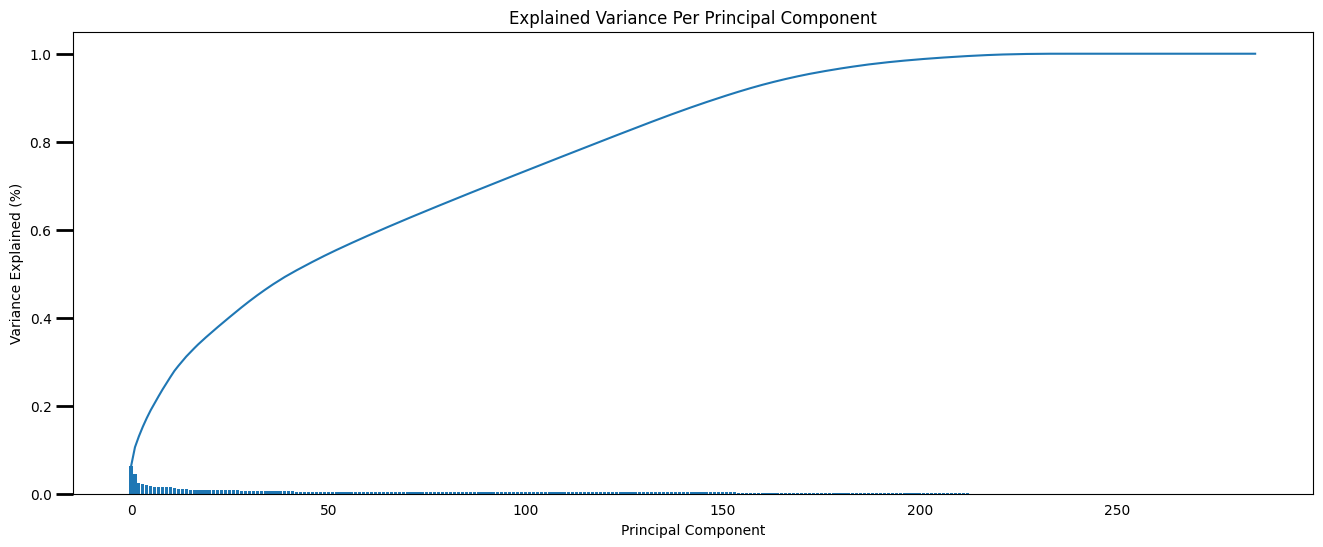

In [51]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca,show_labels=False):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(16, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    
    if show_labels:
        for i in range(num_components):
            ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

scree_plot(pca)


In [52]:
def pca_results(full_dataset, pca):
	'''
	Create PCA df
	Includes the individual explained variance and also the cummulative var.
	'''

	# Dim index
	dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

	# PCA component
	components = pd.DataFrame(np.round(pca.components_, 4))
	components.index = dimensions

	# PCA-explained variance
	ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
	variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
	variance_ratios.index = dimensions

	# Return concatenated df
	return variance_ratios

azdias_pca_result=pca_results(azdias_is, pca)
azdias_pca_result['Cumulatively Explained Variance']=azdias_pca_result['Explained Variance'].cumsum()
print(azdias_pca_result[azdias_pca_result['Cumulatively Explained Variance']<=0.83])

               Explained Variance  Cumulatively Explained Variance
Dimension 1                0.0619                           0.0619
Dimension 2                0.0438                           0.1057
Dimension 3                0.0249                           0.1306
Dimension 4                0.0219                           0.1525
Dimension 5                0.0197                           0.1722
...                           ...                              ...
Dimension 124              0.0035                           0.8145
Dimension 125              0.0035                           0.8180
Dimension 126              0.0035                           0.8215
Dimension 127              0.0035                           0.8250
Dimension 128              0.0035                           0.8285

[128 rows x 2 columns]


### Decision time on PCA subset: retain 128 
-  ~40 components explain 50% variance
-  ~80 components explain 66% variance
- 105 components explain 75% variance
- 120 components explain 80% variance
- 135 components explain 85% variance
- 150 components explain 90% variance

In [53]:
# Re-apply PCA selecting no. of components to retain.
pca = PCA(n_components=128, random_state=42)
azdias_pca = pca.fit_transform(azdias_is)

### Discussion 2.2: Perform Dimensionality Reduction 284:128

Starting from 284 features (after feat. eng., cleaning, OH-encoding, imputation etc.) we focus on the most 'productive' segment of the PCA scree plot:

-  ~80 (~1/3 of the) components explain 66% (~2/3 of the) variance
- 105 components explain 75% variance
- 120 components explain 80% variance
- 135 (<1/2 of the) components explain 85% (~9/10 of the) variance

=> Starting choice: Dimensions [0-127] (power of 2 for efficiency) cumulatively explain 83% of the variance.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

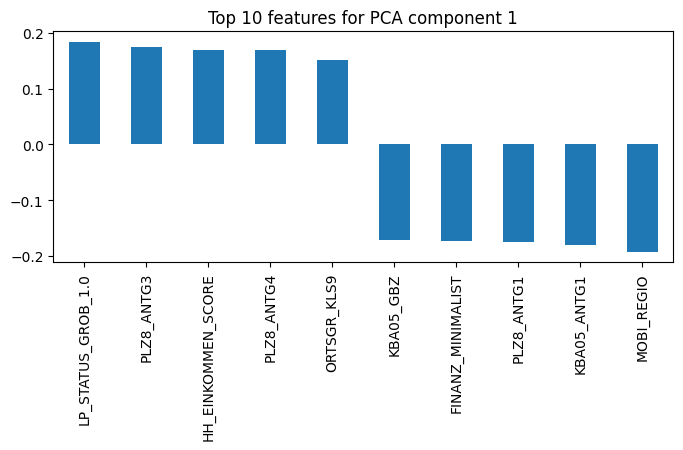

LP_STATUS_GROB_1.0    0.1836
PLZ8_ANTG3            0.1736
HH_EINKOMMEN_SCORE    0.1699
PLZ8_ANTG4            0.1682
ORTSGR_KLS9           0.1505
KBA05_GBZ            -0.1707
FINANZ_MINIMALIST    -0.1736
PLZ8_ANTG1           -0.1744
KBA05_ANTG1          -0.1799
MOBI_REGIO           -0.1928
Name: 0, dtype: float64


In [54]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def pca_plot(df, pca, comp_no, feat_no):
    
    # Build df w/ the feat_no resonsible for most variability for comp_no
    pca_comp = pd.DataFrame(np.round(pca.components_, 4), columns=df.keys()).iloc[comp_no - 1]
    pca_comp.sort_values(ascending=False, inplace=True)
    pca_comp = pd.concat([pca_comp.head(feat_no), pca_comp.tail(feat_no)])
       
    # Plot in default color/blue
    pca_comp.plot(kind='bar', 
                  title='Top {} features for PCA component {}'.format(feat_no*2, comp_no),
                  figsize=(8, 3))
    plt.show()
    
    return pca_comp

# test 1t principal component
p = pca_plot(azdias_is, pca, 1, 5)
print(p)


###  1st Component PCA
+correlation between social status, household net income, large family homes, community size.

-correlation with housing density, movement patterns, small family homes, and low financial interest.
- LP_STATUS_GROB_1.0    0.1842 => Status
- PLZ8_ANTG3            0.1736 => 6-10 family houses in region
- HH_EINKOMMEN_SCORE    0.1701 => Est. Household net income
- PLZ8_ANTG4            0.1680 => 10+ family homes in region
- ORTSGR_KLS9           0.1511 => Size of community
- KBA05_GBZ            -0.1711 => Number of buildings in the microcell
- PLZ8_ANTG1           -0.1739 => Number of 1-2 family houses in the PLZ8 region
- FINANZ_MINIMALIST    -0.1747 => (shows) low financial interest
- KBA05_ANTG1          -0.1800 => Number of 1-2 family houses in the microcell
- MOBI_REGIO           -0.1933 => Movement patterns

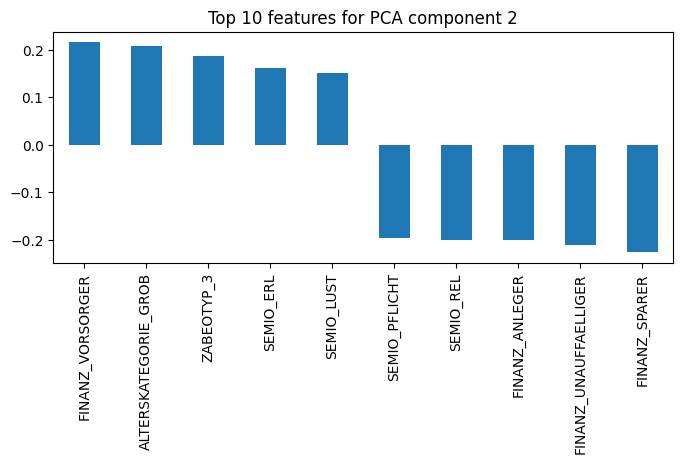

FINANZ_VORSORGER         0.2156
ALTERSKATEGORIE_GROB     0.2071
ZABEOTYP_3               0.1872
SEMIO_ERL                0.1606
SEMIO_LUST               0.1517
SEMIO_PFLICHT           -0.1964
SEMIO_REL               -0.1993
FINANZ_ANLEGER          -0.2003
FINANZ_UNAUFFAELLIGER   -0.2107
FINANZ_SPARER           -0.2261
Name: 1, dtype: float64


In [55]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
p = pca_plot(azdias_is, pca, 2, 5)
print(p)


###  2nd Component PCA
+correlation => provider, age, event-oriented, hedonic...

-correlation => saver, investor, dutiful, religious...
- FINANZ_VORSORGER         0.2161 => Provider, financially prepared
- ALTERSKATEGORIE_GROB     0.2069 => Estimated age based on given name analysis
- ZABEOTYP_3               0.1873 => Energy consumption typology, fair supplied
- SEMIO_ERL                0.1606 => Personality typology, event-oriented
- SEMIO_LUST               0.1516 => Personality typology, sensual / hedonistic
- SEMIO_PFLICHT           -0.1958 => Personality typology, dutiful
- SEMIO_REL               -0.1989 => Personality typology, religious
- FINANZ_ANLEGER          -0.2009 => Investor
- FINANZ_UNAUFFAELLIGER   -0.2095 => Inconspicuous
- FINANZ_SPARER           -0.2255 => Saver

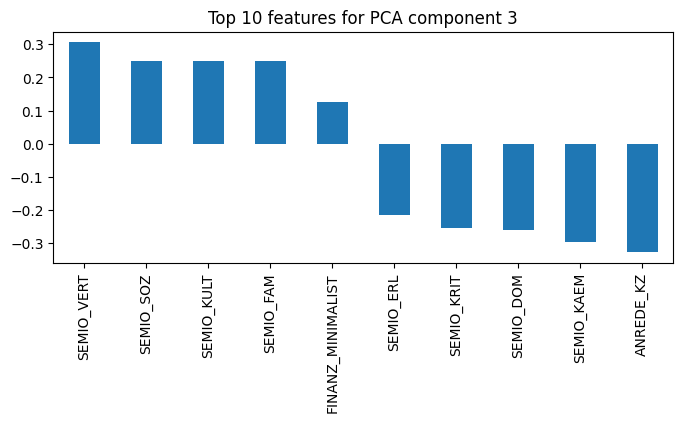

SEMIO_VERT           0.3065
SEMIO_SOZ            0.2511
SEMIO_KULT           0.2494
SEMIO_FAM            0.2487
FINANZ_MINIMALIST    0.1251
SEMIO_ERL           -0.2150
SEMIO_KRIT          -0.2548
SEMIO_DOM           -0.2595
SEMIO_KAEM          -0.2962
ANREDE_KZ           -0.3276
Name: 2, dtype: float64


In [56]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
p = pca_plot(azdias_is, pca, 3, 5)
print(p)


###  3rd Component PCA
+correlation => gender, fighter, dominant, criticizer...

-correlation => family-oriented, dreamer, low financial interests, culture, social...
- ANREDE_KZ            0.3275 => Gender (1-M, 2-F)
- SEMIO_KAEM           0.2956 => Personality: Combative Attitude
- SEMIO_DOM            0.2588 => Personality: Dominant-minded	
- SEMIO_KRIT           0.2543 => Personality: Critical-minded	
- SEMIO_ERL            0.2150 => Personality: Event-oriented
- FINANZ_MINIMALIST   -0.1246 => Financial typology: low financial interest
- SEMIO_FAM           -0.2490 => Personality: Family-minded
- SEMIO_KULT          -0.2492 => Personality: Cultural-minded
- SEMIO_SOZ           -0.2509 => Personality: Socially-minded
- SEMIO_VERT          -0.3061 => Personality: Dreamful

In [57]:
# How reliable are the top 3 components vs. the full dataset?
pca.explained_variance_ratio_[:3].sum()

0.13057844037319385

### Discussion 2.3: Interpret Principal Components

####  1st Component PCA => Financial, status, wealth, estate
+correlation between social status, household net income, large family homes, community size.

-correlation with housing density, movement patterns, small family homes, and low financial interest.

####  2nd Component PCA => Personality / character and age
+correlation => provider, age, event-oriented, hedonic...

-correlation => saver, investor, dutiful, religious...

####  3rd Component PCA => Personality / leadership, gender
+correlation => gender, fighter, dominant, criticizer...

-correlation => family-oriented, dreamer, low financial interests, culture, social...

However intuitive, all the above features cumulated can explain merely 13% of the variance; hence the need for further analysis.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

Segment#1, K= 3-11 yields a line w/o curvature :-(

Segment#2, K= 11-20 yields a line w/ small inflexions; will re-fit the K-means with step 1

Segment#3, K=20-32 yields a line with inflexion around k=24 (too high for practical use!)

In [ ]:
# re-run all K=4-36, step 4
score = {}
for k in range(4,36,4):
    # run k-means clustering 
    score[k] = np.abs(KMeans(n_clusters=k, n_init=8).fit(azdias_pca).score(azdias_pca))
    print('K=',k, 'SSE=',score[k])
print(score)

Text(0, 0.5, 'SSE score / Total distance to centroids')

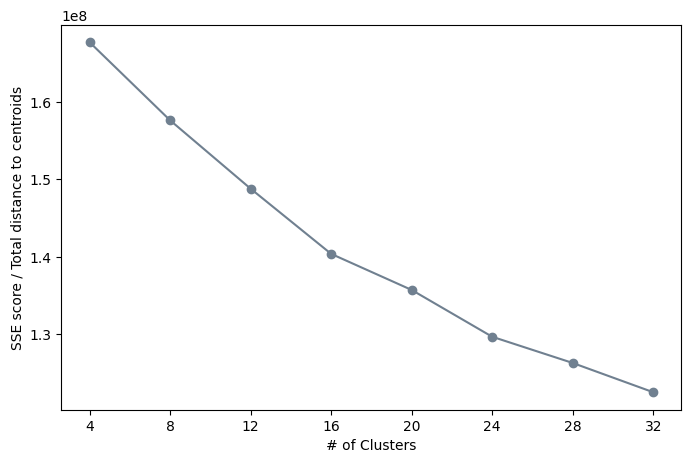

In [60]:
# Adjust the x-axis ticks to match the available keys in our data
x_ticks = np.array(list(score.keys()))

# Plot the SSE scores
fig, ax = plt.subplots(figsize=(8,5))    
ax = pd.Series(score).plot(marker='o', color='slategray')
ax.set_xticks(x_ticks, minor=False)
ax.set_xlabel("# of Clusters")
ax.set_ylabel("SSE score / Total distance to centroids")

### Step 4 doesn't reveal any elbow; try step 1, then silhouette...

{4: 166208005.42070496, 5: 163042859.42951027, 6: 160798836.01562145, 7: 158121605.89577234, 8: 155201658.7181421, 9: 153761151.80872482, 10: 151221039.74029517, 11: 149317642.85854292, 12: 146446145.339635, 13: 145513202.3438724, 14: 143539707.52487576, 15: 141976383.69736385, 16: 140989756.81171888, 17: 136221237.41200042, 18: 137410490.73507592, 19: 135384378.22883153, 20: 134384398.41719872, 21: 133354958.37676018, 22: 130871784.10723785, 23: 130871343.12289357, 24: 128758328.65348282, 25: 127003426.59056313, 26: 126893367.69323432, 27: 124916346.3090513}


Text(0, 0.5, 'Total Distance to centroid')

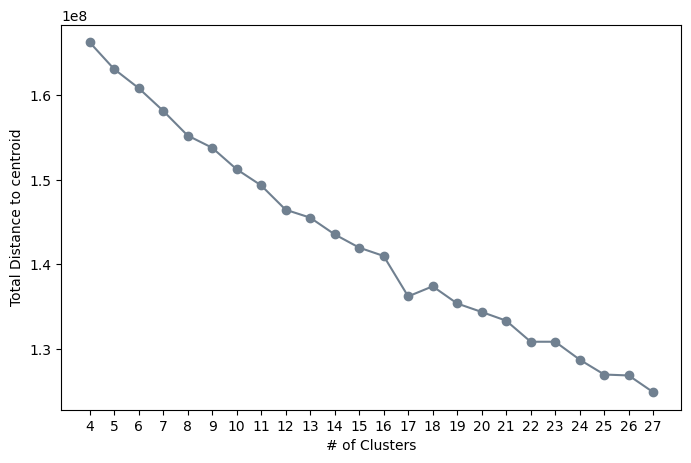

In [122]:
# # re-run all K=4-36, step 1 (slow!)
# score = {}
# for k in range(4,36,4):
#     # run k-means clustering 
#     score[k] = np.abs(KMeans(n_clusters=k, n_init=8).fit(azdias_pca).score(azdias_pca))
#     print('K=',k, 'SSE=',score[k])
# print(score)

The plots with steps 1 and 2 have neither inflexions nor elbow points; possibly statistical artifacts (e.g., due to K-mean's n_init) are visible at K=22 and  K=17 (SSE= 136221237...)

In [61]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters=16, n_init=8)
final_model = kmeans.fit(azdias_pca)


#### Final fit the general population with K-Mean cluster model 

In [62]:
gen_kmean = final_model.predict(azdias_pca)

### Discussion 3.1: Apply Clustering to General Population

#### General considerations 
Domain Knowledge: Consider the nature of our data and the problem we're trying to solve. Sometimes, domain knowledge can provide insights into the expected number of clusters. For example, if we are dealing with customer segmentation, the number of distinct customer segments may be known based on business rules or market research.

Practical Implications: Consider also the practical implications of having a certain number of clusters, e.g., 8-16. Will the resulting clusters be useful and actionable? Will they help you achieve our goals or answer the questions we have about our data?

Since 
- (a) our large corpus (800K rows and 135 columns, from 284...!) can't be trivially compressed into just a few clusters, 
- (b) I lack the SME and/or tribal knowledge in the field,  
i'll choose k=16 clusters based on the above. 

Obs: GMM and EM could be also used later to refine these results.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [72]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [73]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

clean_cust = clean_data(customers)

C:\Users\970986848\AppData\Local\Temp\ipykernel_5228\2177887934.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('no_na_row',inplace=True,axis=1)


In [74]:
clean_cust.shape

(141665, 270)

In [75]:
# quick check the miss counts
print(clean_cust.isnull().sum()[clean_cust.isnull().sum()>0])

ALTERSKATEGORIE_GROB      233
GEBURTSJAHR             45404
HEALTH_TYP               2326
RETOURTYP_BK_S           3106
VERS_TYP                 2326
ALTER_HH                21580
W_KEIT_KIND_HH           7902
ANZ_HAUSHALTE_AKTIV      2431
ANZ_HH_TITEL             2164
KONSUMNAEHE                 6
KBA05_ANTG1              5993
KBA05_ANTG2              5993
KBA05_ANTG3              5993
KBA05_ANTG4              5993
KBA05_GBZ                5995
BALLRAUM                   32
EWDICHTE                   32
INNENSTADT                 32
KKK                     10090
MOBI_REGIO               5993
ONLINE_AFFINITAET        3106
REGIOTYP                10090
KBA13_ANZAHL_PKW         1313
PLZ8_ANTG1               2777
PLZ8_ANTG2               2777
PLZ8_ANTG3               2777
PLZ8_ANTG4               2777
PLZ8_HHZ                 2777
PLZ8_GBZ                 2777
ARBEIT                    572
ORTSGR_KLS9               549
RELAT_AB                  572
decade                  37961
movement  

In [76]:
# clean and fix the OHE feats
mis_col=[]
for i in azdias_is.columns:
    if i not in clean_cust.columns:
        mis_col.append(i)
        #print(i)
print(mis_col)

['AGER_TYP_-1', 'AGER_TYP_0', 'AGER_TYP_1', 'AGER_TYP_2', 'AGER_TYP_3', 'LP_FAMILIE_FEIN_0.0', 'LP_FAMILIE_GROB_0.0', 'NATIONALITAET_KZ_0', 'NATIONALITAET_KZ_1', 'NATIONALITAET_KZ_2', 'NATIONALITAET_KZ_3', 'SHOPPER_TYP_-1', 'SHOPPER_TYP_0', 'SHOPPER_TYP_1', 'SHOPPER_TYP_2', 'SHOPPER_TYP_3', 'TITEL_KZ_0.0', 'TITEL_KZ_2.0', 'VERS_TYP_-1', 'VERS_TYP_1', 'VERS_TYP_2', 'GEBAEUDETYP_5.0', 'LP_LEBENSPHASE_FEIN_0.0', 'LP_LEBENSPHASE_GROB_0.0', 'KBA05_BAUMAX_0.0']


In [77]:
# handle the discrepant columns
# List of currently missing columns
# mis_col = ['AGER_TYP_-1', 'AGER_TYP_0', 'AGER_TYP_1', 'AGER_TYP_2', 'AGER_TYP_3',
#                    'LP_FAMILIE_FEIN_0.0', 'LP_FAMILIE_GROB_0.0',
#                    'NATIONALITAET_KZ_0', 'NATIONALITAET_KZ_1', 'NATIONALITAET_KZ_2', 'NATIONALITAET_KZ_3',
#                    'SHOPPER_TYP_-1', 'SHOPPER_TYP_0', 'SHOPPER_TYP_1', 'SHOPPER_TYP_2', 'SHOPPER_TYP_3',
#                    'TITEL_KZ_0.0', 'TITEL_KZ_2.0', 'VERS_TYP_-1', 'VERS_TYP_1', 'VERS_TYP_2',
#                    'GEBAEUDETYP_5.0', 'LP_LEBENSPHASE_FEIN_0.0', 'LP_LEBENSPHASE_GROB_0.0', 'KBA05_BAUMAX_0.0']

# Iterate our missing cols
for col in mis_col:
    if col not in clean_cust.columns:
        print(f"Fix missing column: {col}")
        # make new pd series w/ 0s
        new_column = pd.Series(np.zeros(clean_cust.shape[0]), name=col, index=clean_cust.index)
        clean_cust[col] = new_column

# re-order cols to match our original df
clean_cust = clean_cust[azdias_is.columns]


Fix missing column: AGER_TYP_-1
Fix missing column: AGER_TYP_0
Fix missing column: AGER_TYP_1
Fix missing column: AGER_TYP_2
Fix missing column: AGER_TYP_3
Fix missing column: LP_FAMILIE_FEIN_0.0
Fix missing column: LP_FAMILIE_GROB_0.0
Fix missing column: NATIONALITAET_KZ_0
Fix missing column: NATIONALITAET_KZ_1
Fix missing column: NATIONALITAET_KZ_2
Fix missing column: NATIONALITAET_KZ_3
Fix missing column: SHOPPER_TYP_-1
Fix missing column: SHOPPER_TYP_0
Fix missing column: SHOPPER_TYP_1
Fix missing column: SHOPPER_TYP_2
Fix missing column: SHOPPER_TYP_3
Fix missing column: TITEL_KZ_0.0
Fix missing column: TITEL_KZ_2.0
Fix missing column: VERS_TYP_-1
Fix missing column: VERS_TYP_1
Fix missing column: VERS_TYP_2
Fix missing column: GEBAEUDETYP_5.0
Fix missing column: LP_LEBENSPHASE_FEIN_0.0
Fix missing column: LP_LEBENSPHASE_GROB_0.0
Fix missing column: KBA05_BAUMAX_0.0


In [78]:
# clean_cust.shape
if clean_cust.shape[1] == azdias_is.shape[1]:
    print("The number of columns in (cleaned) customer matches the number of columns of azdias.")
else:
    print("The number of columns in (cleaned) customer does not match the number of columns from azdias")


The number of columns in (cleaned) customer matches the number of columns of azdias.


In [79]:
imputed = imputer.transform(clean_cust)
standardized = scaler.transform(imputed)

In [80]:
# Convert the NumPy array back to a DataFrame
cust_is = pd.DataFrame(data=standardized, columns=clean_cust.columns)
print(cust_is.shape)

(141665, 286)


In [81]:
# PCA
X_pca_cust = pca.transform(cust_is)

In [82]:
X_pca_cust.shape

(141665, 128)

In [83]:
cust_kmean = final_model.predict(X_pca_cust)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

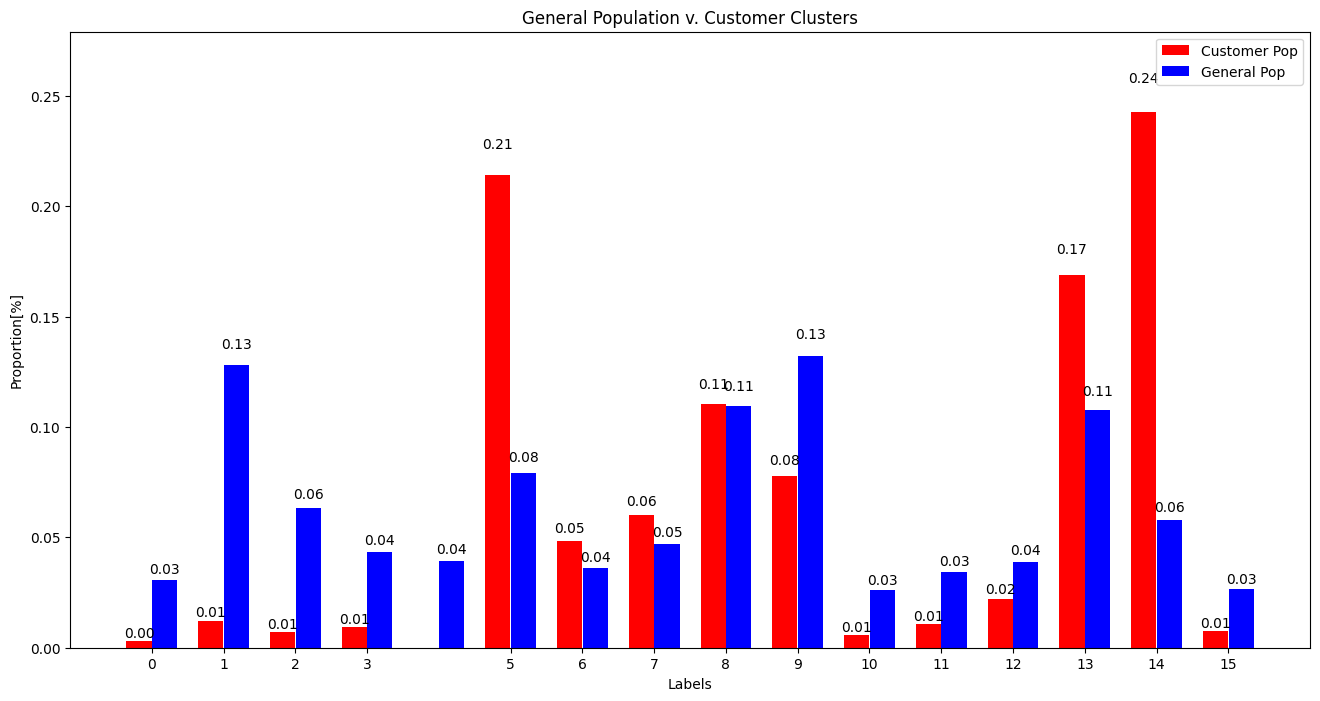

In [86]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

cust_clust = pd.DataFrame(cust_kmean,columns=['cust_preds'])
gen_clust =  pd.DataFrame(gen_kmean,columns=['gen_preds'])

prop_cust = cust_clust['cust_preds'].value_counts().sort_index()/ \
                sum(cust_clust['cust_preds'].value_counts())
prop_gen = gen_clust['gen_preds'].value_counts().sort_index()/ \
                sum(gen_clust['gen_preds'].value_counts())

fig,ax = plt.subplots(figsize=(16,8))
width = 0.35

cust = ax.bar(prop_cust.index-.51*width, prop_cust, width, color='red')
gen = ax.bar(prop_gen.index+.51*width, prop_gen, width, color='blue')


ax.set_ylabel('Proportion[%]')
ax.set_xlabel('Labels')
ax.set_title('General Population v. Customer Clusters')
ax.set_xticks(prop_cust.index)
ax.set_ylim(top=max(pd.concat([prop_cust, prop_gen])) * 1.15)
ax.legend(('Customer Pop','General Pop'))

def autolabel(rects):
    """
    local labels / bar
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%.2f' % float(height),
                ha='center', va='bottom')

autolabel(cust)
autolabel(gen)

### On 1st run (not shown above) => Customers are

#### Under-represented

- 3: 8x
- 4: 5x
- 7: 5x
- 9: 6x

#### Over-represented

- 2: 2x
- 10: 3x
- 14: 3x

Overall at the first glance the customers seem significantly more under-represented vs. the general population.

Multiple runs w/ new clustering fits yield different centroid indexes and % ratios, yet the general conclusions are further validated.

In [182]:
azdias_is.shape
azdias_pca.shape

(798003, 128)

In [208]:
# What kinds of people are part of a cluster that is over-represented in the
# customer data compared to the general population?

# Selected centroids
selected_centroids = [2, 10, 14]

# Iterate over selected centroids
for centroid_idx in selected_centroids:
    centroid = final_model.cluster_centers_[centroid_idx]
    centroid_df = pd.DataFrame(centroid, columns=['pca_weights'])
    
    # Sort PCA weights by absolute value in descending order
    sorted_centroid_df = centroid_df.reindex(centroid_df['pca_weights'].abs().sort_values(ascending=False).index).head()
    
    # Print the head of sorted_centroid_df
    print(f"Top PCA components for over-represented clusters {centroid_idx}:")
    print(sorted_centroid_df)
    print("===================================================")



Top PCA components for over-represented clusters 2:
    pca_weights
0     -5.112286
7     -2.989457
5     -2.219828
22    -1.591686
16     1.501476
Top PCA components for over-represented clusters 10:
    pca_weights
10     6.017229
9      3.734508
0     -2.139783
15    -2.025592
2     -1.661668
Top PCA components for over-represented clusters 14:
    pca_weights
0     -4.542427
5      2.794925
3      1.923854
10    -1.273394
13     1.130356


In [209]:
# What kinds of people are part of a cluster that is under-represented in the
# customer data compared to the general population?

# Selected centroids
selected_centroids = [3, 4, 7, 9] 

# Iterate over selected centroids
for centroid_idx in selected_centroids:
    centroid = final_model.cluster_centers_[centroid_idx]
    centroid_df = pd.DataFrame(centroid, columns=['pca_weights'])
    
    # Sort PCA weights by absolute value in descending order
    sorted_centroid_df = centroid_df.reindex(centroid_df['pca_weights'].abs().sort_values(ascending=False).index).head()
    
    # Print the head of sorted_centroid_df
    print(f"Top PCA components for under-represented clusters {centroid_idx}:")
    print(sorted_centroid_df)
    print("===================================================")


Top PCA components for under-represented clusters 3:
    pca_weights
0      4.996420
1     -3.252104
3     -1.333543
14     1.159692
9     -1.111062
Top PCA components for under-represented clusters 4:
    pca_weights
0      4.975596
1     -1.788617
38     1.438618
42     1.238119
82     1.220609
Top PCA components for under-represented clusters 7:
    pca_weights
1     -3.257242
3     -2.915600
7      1.955927
8      1.841317
19     1.590107
Top PCA components for under-represented clusters 9:
    pca_weights
1     -4.334771
6     -3.137063
3      2.283249
19    -2.038985
5     -1.868824


### Perform visual exploration of selected top PCA components and associated features (based on our 1st clustering fit)
- for the most interesting centroids from our lists 
- over [2, 10, 14]
- under  [3, 4, 7, 9] 
- select the top PCA components for under- & over-represented clusters,
- plot the top 10 features,
- reason based on common sense, or ideally w/ SME help, the categories.

In [218]:
# e.g., sample of over-represented cluster
centroid = final_model.cluster_centers_[10]
centroid_df = pd.DataFrame(centroid,columns=['pca_weights'])
centroid_df.reindex(centroid_df.abs().sort_values('pca_weights',ascending=False).index).head()

,pca_weights
10,6.017229
9,3.734508
0,-2.139783
15,-2.025592
2,-1.661668


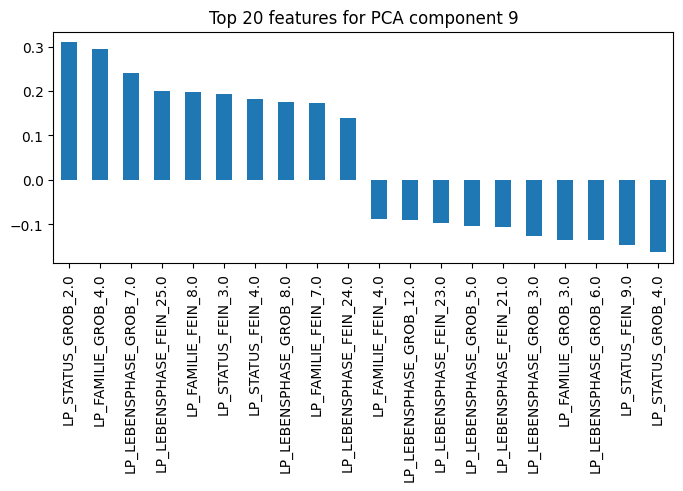

LP_STATUS_GROB_2.0          0.3095
LP_FAMILIE_GROB_4.0         0.2938
LP_LEBENSPHASE_GROB_7.0     0.2401
LP_LEBENSPHASE_FEIN_25.0    0.2004
LP_FAMILIE_FEIN_8.0         0.1980
LP_STATUS_FEIN_3.0          0.1926
LP_STATUS_FEIN_4.0          0.1831
LP_LEBENSPHASE_GROB_8.0     0.1747
LP_FAMILIE_FEIN_7.0         0.1740
LP_LEBENSPHASE_FEIN_24.0    0.1392
LP_FAMILIE_FEIN_4.0        -0.0886
LP_LEBENSPHASE_GROB_12.0   -0.0903
LP_LEBENSPHASE_FEIN_23.0   -0.0958
LP_LEBENSPHASE_GROB_5.0    -0.1028
LP_LEBENSPHASE_FEIN_21.0   -0.1062
LP_LEBENSPHASE_GROB_3.0    -0.1249
LP_FAMILIE_GROB_3.0        -0.1344
LP_LEBENSPHASE_GROB_6.0    -0.1344
LP_STATUS_FEIN_9.0         -0.1462
LP_STATUS_GROB_4.0         -0.1625
Name: 8, dtype: float64

In [222]:
# Over cluster 10, top + => comp. 10	w= +6.017229
pca_plot(azdias_is, pca, 9, 10)

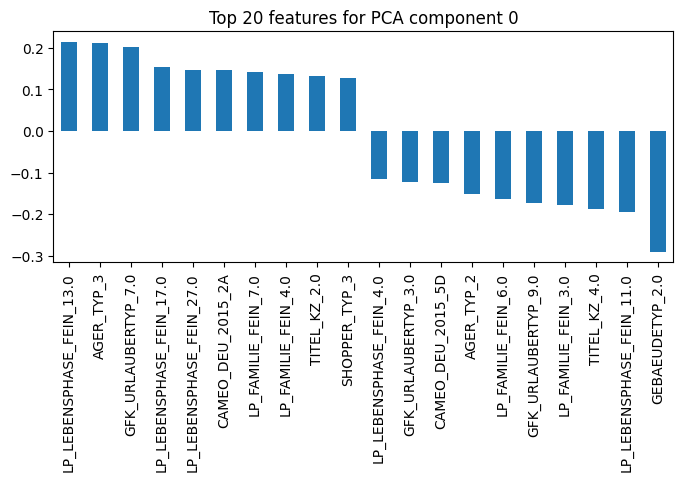

LP_LEBENSPHASE_FEIN_13.0    0.2144
AGER_TYP_3                  0.2110
GFK_URLAUBERTYP_7.0         0.2012
LP_LEBENSPHASE_FEIN_17.0    0.1540
LP_LEBENSPHASE_FEIN_27.0    0.1475
CAMEO_DEU_2015_2A           0.1463
LP_FAMILIE_FEIN_7.0         0.1415
LP_FAMILIE_FEIN_4.0         0.1368
TITEL_KZ_2.0                0.1331
SHOPPER_TYP_3               0.1274
LP_LEBENSPHASE_FEIN_4.0    -0.1166
GFK_URLAUBERTYP_3.0        -0.1238
CAMEO_DEU_2015_5D          -0.1243
AGER_TYP_2                 -0.1526
LP_FAMILIE_FEIN_6.0        -0.1626
GFK_URLAUBERTYP_9.0        -0.1729
LP_FAMILIE_FEIN_3.0        -0.1784
TITEL_KZ_4.0               -0.1881
LP_LEBENSPHASE_FEIN_11.0   -0.1954
GEBAEUDETYP_2.0            -0.2911
Name: 127, dtype: float64

In [224]:
# Over cluster 10, top - => comp. 0	w= -2.139783
pca_plot(azdias_is, pca, 0, 10)

In [225]:
# e.g., sample of under-represented cluster
centroid = final_model.cluster_centers_[3]
centroid_df = pd.DataFrame(centroid,columns=['pca_weights'])
centroid_df.reindex(centroid_df.abs().sort_values('pca_weights',ascending=False).index).head()

,pca_weights
0,4.996420
1,-3.252104
3,-1.333543
14,1.159692
9,-1.111062


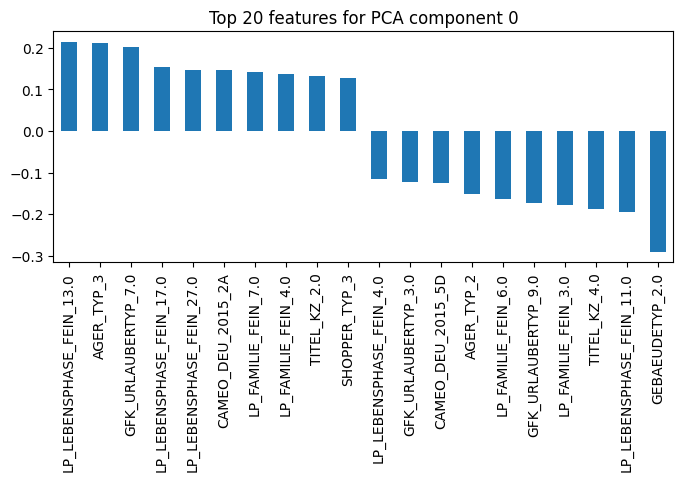

LP_LEBENSPHASE_FEIN_13.0    0.2144
AGER_TYP_3                  0.2110
GFK_URLAUBERTYP_7.0         0.2012
LP_LEBENSPHASE_FEIN_17.0    0.1540
LP_LEBENSPHASE_FEIN_27.0    0.1475
CAMEO_DEU_2015_2A           0.1463
LP_FAMILIE_FEIN_7.0         0.1415
LP_FAMILIE_FEIN_4.0         0.1368
TITEL_KZ_2.0                0.1331
SHOPPER_TYP_3               0.1274
LP_LEBENSPHASE_FEIN_4.0    -0.1166
GFK_URLAUBERTYP_3.0        -0.1238
CAMEO_DEU_2015_5D          -0.1243
AGER_TYP_2                 -0.1526
LP_FAMILIE_FEIN_6.0        -0.1626
GFK_URLAUBERTYP_9.0        -0.1729
LP_FAMILIE_FEIN_3.0        -0.1784
TITEL_KZ_4.0               -0.1881
LP_LEBENSPHASE_FEIN_11.0   -0.1954
GEBAEUDETYP_2.0            -0.2911
Name: 127, dtype: float64

In [226]:
# Under cluster 3, top + => comp. 0	w= +4.9964
pca_plot(azdias_is, pca, 0, 10)

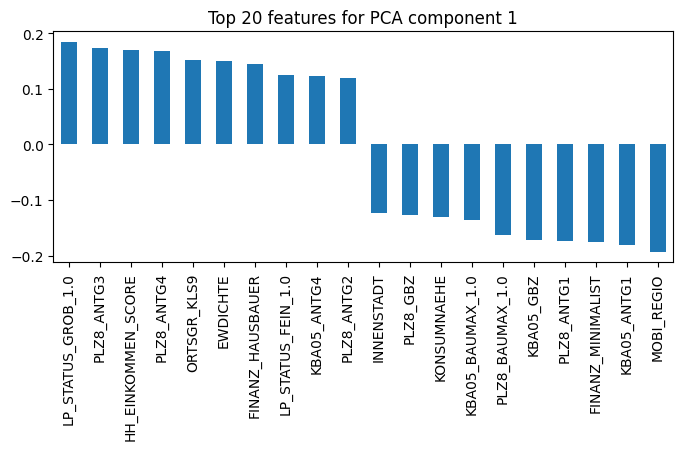

LP_STATUS_GROB_1.0    0.1842
PLZ8_ANTG3            0.1736
HH_EINKOMMEN_SCORE    0.1701
PLZ8_ANTG4            0.1680
ORTSGR_KLS9           0.1511
EWDICHTE              0.1492
FINANZ_HAUSBAUER      0.1439
LP_STATUS_FEIN_1.0    0.1240
KBA05_ANTG4           0.1231
PLZ8_ANTG2            0.1199
INNENSTADT           -0.1232
PLZ8_GBZ             -0.1271
KONSUMNAEHE          -0.1302
KBA05_BAUMAX_1.0     -0.1364
PLZ8_BAUMAX_1.0      -0.1632
KBA05_GBZ            -0.1711
PLZ8_ANTG1           -0.1739
FINANZ_MINIMALIST    -0.1747
KBA05_ANTG1          -0.1800
MOBI_REGIO           -0.1933
Name: 0, dtype: float64

In [227]:
# Under cluster 3, top - => comp. 1	w= -3.25
pca_plot(azdias_is, pca, 1, 10)

### Discussion 3.3: Compare Customer Data to Demographics Data

Again, the key centroids analysed were based on the 1st run and K-mean fit (and validated by 3 more runs after)

#### Under-represented
- 3: 8x
- 4: 5x
- 7: 5x
- 9: 6x

#### Over-represented
- 2: 2x
- 10: 3x
- 14: 3x

**Analysis and Discussion:**

Aggregating these preliminary insights from a limited range of analyses (5 runs; non-SME student, single clustering, rash decisions in feat. eng. etc.), an early  understanding of customer segmentation and preferences for the mail-order company comes into focus. We attempt a first perspective on the segments that are relatively popular or unpopular with the company, offering our arguable guidance for targeted marketing strategies.

**Relatively Popular Customer Segments:**

1. **Distinct Cluster Attributes**: Clusters that are overrepresented in customer data exhibit common traits. These individuals are often wealthier, residing in larger households, and leaning towards conservative financial habits. They tend to be rational, materialistic, and dutiful, with characteristics that are more aligned with traditional values.

2. **Affluent Older Demographics**: An evident pattern emerges among segments that consist of older, more affluent individuals. This demographic is characterized by higher financial status, a penchant for wealth accumulation, and a preference for larger residences.

3. **Psychological Traits**: Overrepresented segments often encompass individuals who demonstrate rational financial behaviors, are less dreamful and socially-minded, and live in less densely populated areas.

**Relatively Unpopular Customer Segments:**

1. **Diverse Cluster Attributes**: Clusters underrepresented in customer data share varying characteristics. This includes environmentally conscious individuals living in densely populated regions with higher unemployment rates and segments comprised of younger individuals with lower financial awareness and status.

2. **Challenges with Younger Audiences**: Younger individuals, particularly females, stand out as being relatively unpopular among the customer base. These segments often lack financial involvement, exhibit less conservative attitudes, and reside in densely populated areas.

3. **Psychological Traits**: Unpopular segments also tend to possess attributes such as high financial interest, rationality, combative attitudes, or being male. These traits align with segments that do not resonate well with the company's offerings.


**Potential Guidance for Marketing Strategy:**

1. **Targeting Older and Wealthier**: Given the prevalence of overrepresented segments that are older and wealthier, it's advisable to direct marketing efforts towards this demographic. Crafting campaigns that emphasize affluence and financial stability could be effective.

2. **Tailoring Psychological Messaging**: Understanding the psychological traits associated with both popular and unpopular segments provides an opportunity to craft messaging that resonates with each group's values and aspirations.

3. **Leveraging Environmental and Economic Trends**: The environmentally conscious segments can be tapped into by aligning marketing efforts with green initiatives. On the other hand, addressing financial awareness among younger demographics is crucial for engagement.

4. **Balancing Contradictory Traits**: Considering contradictory traits collectively, marketers should aim to identify potential customers based on combinations of attributes. This can provide a nuanced approach to reaching diverse audiences.

In conclusion, this preliminary analysis draws from a range of k-mean cluster&PCA investigations, enabling the mail-order company to shape a sophisticated marketing strategy. By focusing on identified segments and crafting messaging that addresses the above mentioned attributes and traits, the company can position itself for success in attracting and engaging a wide-ranging customer base.


**Limitations of our ML Analysis:**

1. **Limited Number of Clusters:** The K-means clustering utilized only 16 clusters due to the absence of a clear elbow point in the sum of squared errors (SSE) curve. This limited granularity might not capture the intricate patterns within the data, leading to oversimplification of customer segments.

2. **Lack of Ground Truth:** The absence of ground truth labels makes it challenging to objectively evaluate the clustering results. While domain expertise was employed, subjective interpretation can introduce bias into the segmentation process.

3. **Cluster Interpretability:** Interpreting the meaning behind the clusters can be complex, as they are composed of high-dimensional principal components. Connecting these components to actionable insights can be challenging and might require further domain-specific knowledge.

4. **Data Transformation Impact:** The reduction of features through PCA (from 284 to 128) introduces the risk of information loss. While it aids in dimensionality reduction, it might mask subtle nuances that play a crucial role in customer segmentation. We also dropped ca. 10% of the samples (93K rows), despite the KS tests advising to the contrary; hence we may have introduced a bias distorting our conclusions...?

5. **Sensitive to Initialization:** The performance of K-means clustering can vary based on the initial placement of centroids. Different random initializations can lead to slightly different cluster assignments, impacting the stability of the results.

**Future Work:**

1. **Alternative Clustering Algorithms:** Exploring other clustering methods such as hierarchical clustering, DBSCAN, or Gaussian Mixture Models and EM could provide different perspectives on the data structure, potentially revealing more meaningful clusters.

2. **Feature Engineering:** Careful selection and engineering of features can improve the quality of the clusters. Exploring new features or transformations might highlight more pronounced patterns.

3. **Dimensionality Reduction Techniques:** Experimenting with other dimensionality reduction methods beyond PCA, such as t-SNE or UMAP, might help retain more of the original data's characteristics while reducing dimensionality.

4. **Evaluation Metrics:** Introducing evaluation metrics like silhouette scores, Davies-Bouldin index, or silhouette plots could provide more objective means to assess the quality of the clustering results.

5. **Hyperparameter Tuning:** Fine-tuning the parameters of the clustering algorithm, including the number of clusters, initialization methods, and convergence criteria, could lead to more stable and accurate segmentation.

6. **Domain Expertise:** Collaborating closely with domain experts and incorporating their insights during both the preprocessing and clustering stages can enhance the accuracy and interpretability of the segmentation.

7. **Ensemble Methods:** Combining results from multiple clustering algorithms through ensemble techniques can provide a more robust and reliable segmentation outcome.

8. **External Validation:** Gathering external data, such as customer demographics or behavioral data, could be used to validate the generated clusters against real-world characteristics.

9. **Iterative Approach:** Segmentation is not a one-time task. Regularly revisiting and updating the analysis based on new data and insights is important to ensure the strategy remains relevant.

In conclusion, while our initial ML analysis provided valuable insights, it's important to acknowledge its limitations. Expanding the analysis through the mentioned future work avenues can enhance the accuracy, stability, and applicability of the customer segmentation process for the mail-order company.

Intangible / remark: After 5 runs with different PCA and K-means, this student could not obtain the resemblance of an elbow in the SSE scores plots. This suggests the need for alternative clustering models and metrics.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.